<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/HTAN/Python%20Notebooks/Analyzing_HTAN_spatial_data_with_BigQuery_geospatial_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing HTAN spatial data with BigQuery spatial analytics

        Title:   Analyzing HTAN spatial data with BigQuery geospatial analytics
        Author:  Boris Aguilar (baguilar@systemsbiology.org) & Vesteinn Thorsson
        Created: 02/14/2024
        Updated: 06/09/2025
        Purpose: Demonstrate BigQuery geospatial analytics on spatial data in HTAN.

# 1. Introduction & Overview
[HTAN](https://humantumoratlas.org/) is a National Cancer Institute (NCI)-funded Cancer Moonshot initiative to construct 3-dimensional atlases of the dynamic cellular, morphological, and molecular features of human cancers as they evolve from precancerous lesions to advanced disease [[Cell April 2020](https://www.sciencedirect.com/science/article/pii/S0092867420303469)].


Many HTAN Research Centers employ highly-multiplexed imaging to gain understanding of molecular processes and interactions at work in the tumor microenvironment.  The study [The Spatial Landscape of Progression and Immunoediting in Primary Melanoma at Single-Cell Resolution](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and), Ajit Nirmal et al, Cancer Discov (2022) 12 (6): 1518–1541, uses multiplexed whole-slide imaging analysis to characterize intermixed and graded morphological and molecular features in human melanoma cancer samples, highlighting large-scale cancer-characteristic structural features. Spatial profiling of proteins and mRNA reveals recurrent morphologic and molecular features of tumor evolution that involve localized paracrine cytokine signaling and direct cell–cell contact.

[Google BigQuery Geospatial Analytics](https://cloud.google.com/bigquery/docs/geospatial-intro) enables seamless and efficient analysis and visualization of geospatial data within Google BigQuery. 

### 1.1 Goal

This notebook offers examples demonstrating how BigQuery spatial analytics can assist in the analysis and exploration of spatial data accessible within HTAN BigQuery tables.

### 1.2 Inputs, Outputs, & Data

This notebook utilizes spatial transcriptomics data from Melanoma samples within the [ISB-CGC HTAN dataset](https://isb-cgc.appspot.com/). Specifically, we will be utilizing the public BigQuery table named [isb-cgc-bq.HTAN_versioned.imaging_level4_HMS_mel_mask_r3](https://bq-search.isb-cgc.org/search?datasetId=%27HTAN_versioned%27&projectId=%27isb-cgc-bq%27&show_details=true&tableId=%27imaging_level4_HMS_mel_mask_r3%27&include_always_newest=true). The originating data can be found on the [HTAN Data Portal](https://data.humantumoratlas.org/).

### 1.3 Notes
The queries and results in this notebook correspond to ISB-CGC HTAN Release 6.0. However, if no modification to the dataset occurred (additions or removals) since a previous release, the existing version remains valid. As a result, some tables retain names ending in `r3`, indicating they have not been updated since Release 3.0, but are still current for Release 6.0.

To choose a different release, edit the BigQuery table names in this notebook by replacing the string `r3` with a selected numbered release, e.g., `r2`. To get results for the most current data release, replace:
- `r3` with `current`
- `HTAN_versioned` with `HTAN`

#
### ⚠️PAUSE
Notebooks associated with ISB-CGC HTAN Releases 6.0 or earlier are based on the **HTAN Phase 1 Data Model**. Please be aware that the structure, terminology, and available data elements may differ from those in Phase 2. 

# 2. Environment and Module setup

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas_gbq

# 3. Google Authentication
Running the BigQuery cells in this notebook requires a Google Cloud Project, instructions for creating a project can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console). The instance needs to be authorized to bill the project for queries. For more information on getting started in the cloud see [Quick Start Guide to ISB-CGC](https://nbviewer.org/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/Quick_Start_Guide_to_ISB_CGC.ipynb) and alternative authentication methods can be found in the [Google Documentation](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console).

## 3.1 Authenticating with Google Credentials

#### Option 1. Running in Google Colab

Before getting started, keep in mind that there are some differences in running this notebook depending on if you are using Google Colab or running locally. We've included notes such as the following to skip or run specific lines of code depending on your setup.

If you are using Google Colab, run the code block below to authenticate:

In [9]:
from google.colab import auth
auth.authenticate_user()

#### Option 2. Running on local machine

Alternatively, if you're running the notebook locally, take the following steps to authenticate.

1.   Run `gcloud auth application-default login` on your local machine
2.   Run the command below replacing `<path to key>` with the path to your credentials file

In [ ]:
# env GOOGLE_APPLICATION_CREDENTIALS='<path to key>'

## 3.2 Initializing the Google BigQuery client

In [4]:
# Import the Google BigQuery client
from google.cloud import bigquery

# Set the Google project that will be billed for this notebook's computations
# Replace <my-project> with your BigQuery Project ID
project_id = "<my-project>"

# Create a client to access the data within BigQuery
client = bigquery.Client(project_id)

# 4. Exploration and analysis of HTAN spatial data with BigQuery

We will focus on imaging data of sample MEL1-1 as described in [the manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and). This tissue section corresponds to HTAN biospecimen `HTA7_1_3`. An excellent [interactive guide](https://labsyspharm.github.io/HTA-MELATLAS-1/stories/MEL1-full-story.html
) to the to multiplex imaging data for this biospecimen is available as [Minerva Story](https://github.com/labsyspharm/minerva-story/wiki).

The necessary data can be found in the BigQuery table [isb-cgc-bq.HTAN_versioned.imaging_level4_HMS_mel_mask_r3](https://bq-search.isb-cgc.org/search?datasetId=%27HTAN_versioned%27&projectId=%27isb-cgc-bq%27&show_details=true&tableId=%27imaging_level4_HMS_mel_mask_r3%27&include_always_newest=true). This table contains estimated marker intensities following cell segmentation, along with data on the location of segmented cells. For our analysis, we will utilize the cell locations denoted by the centroids X_centroid and Y_centroid, representing the coordinates of cells in pixels (where 1 pixel corresponds to 0.65 micrometers).


## 4.1 Labeling tumor cells
First, we will label cancer cells within the samples. As per the manuscript, melanoma (tumor) cells can be distinguished by SOX10 protein abundance. Additionally considering  S100B and CD63 abundance can improve the labeling accuracy. This labeling process involves applying a predefined thresholds for the expression levels of these markers. We calibrated these thresholds manually; but the manuscript provides more details about how to identify cell types from markers.

We focus on a spatial region of HTA7_1_3, characterized as Invasive Melanoma (IM), delineated by the following corner coordinates: lower left (23076.9 px, 9615.3 px) and upper right (30384.6 px, 15000 px). (The region boundaries were obtained by visual matching and conversion of µm to px results in real-valued pixel coordinates).

The follow query is an example of how to label tumor cells using the required markers which are in the columns  `SOX10_cellRingMask`, `S100B_cellRingMask`, and `CD63_cellRingMask`. In addition to retrieving cell centroids for cells in the IM region, and sets celltype to `Tumor` or `Other` using the protein marker thresholds.

In [5]:
query = """
WITH cells AS (
  SELECT  CellID, X_centroid,	Y_centroid,
    IF ( SOX10_cellRingMask > 3704.5 AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 ),
      'Tumor', 'Other'  ) AS celltype
  FROM `isb-cgc-bq.HTAN_versioned.imaging_level4_HMS_mel_mask_r3`
  WHERE HTAN_Biospecimen_ID = 'HTA7_1_3'
)
SELECT CellID, X_centroid,	Y_centroid, celltype
FROM cells
WHERE X_centroid > 23076.9 AND X_centroid < 30384.6
  AND Y_centroid > 9615.3 AND Y_centroid < 15000
"""
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,CellID,X_centroid,Y_centroid,celltype
0,415307,28039.086957,11494.956522,Other
1,416183,27496.301370,11511.171233,Other
2,416188,28020.615385,11503.846154,Other
3,416365,30327.260274,11509.054795,Other
4,416442,29388.388889,11512.270833,Other
...,...,...,...,...
101113,642156,24898.194631,14195.892617,Tumor
101114,642163,25545.954023,14193.896552,Tumor
101115,642166,25766.941667,14195.033333,Tumor
101116,642386,24813.333333,14196.385417,Tumor


The following code generates an image of the location of Tumor and Other cells from the above dataframe. This image is similar to Figure 3A of the [manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and).  

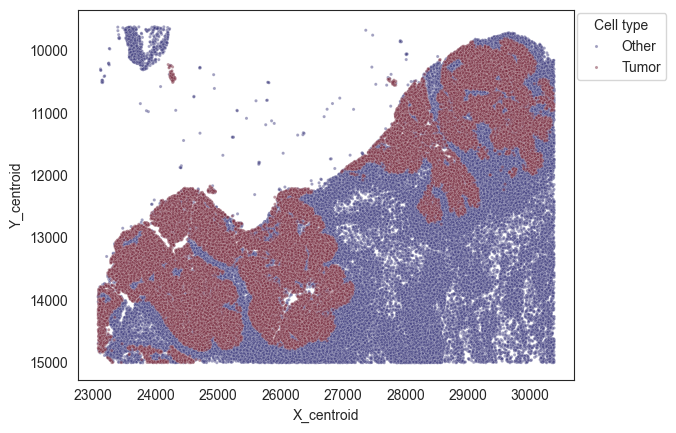

In [6]:
# Set the seaborn theme
sns.set_style("white")

# Let's plot the centroids and color them by marker first:
g=sns.scatterplot(y="Y_centroid", x="X_centroid", hue='celltype', s=5,  data=df, alpha = 0.5, palette="icefire")

sns.move_legend(g, "upper right", title='Cell type',  bbox_to_anchor=(1.2, 1.01))
plt.axis('equal')
g.invert_yaxis() # Flip the y-axis so it aligns with the figure in the publication

## 4.2 Computing local neighborhoods using BigQuery Geospatial analytics

Often, spatial analysis necessitates the identification of neighboring cells which are cell pairs within a specified distance. Here, we employ BigQuery spatial analytics to identify neighboring cells for each tumor cell.

BigQuery operates with distances in spherical geographic coordinate, thus requiring the rescaling of pixel coordinates to latitude and longitude. We found that to keep distance distortion due to mapping between global earth coordinates (spherical coordinates) and slide coordinates within acceptable bounds, the image dimension in pixels should be set to to 0.1 earth angular degrees (or less). For example setting the lower left of the image to the origin in earth geospatial coordinates, the top of slide can be aligned to 0.1 degrees North in latitude. Given that the HTA7_1_3 image dimensions are (36857, 25808) pixels, we rescale the cell coordinates by a factor of 1/258080. Based on this assumption, 20 micrometers on the slide image equates to 13.2 meters, which can be incorporated into BigQuery GIS queries.
  
The following query labels all cells in HTA7_1_3 as either "Tumor" or "Other" and creates a [ST_GeogPoint](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_geogpoint) object defining a geospatial point in BigQuery. Subsequently, the query utilizes the [ST_DWithin](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_within) function to generate a table in which rows correspond to pairs of cells that are closer than 13.2 meters.

In [15]:
query = """
WITH geodat AS(
   SELECT CellID, X_centroid, Y_centroid,
    IF ( SOX10_cellRingMask > 3704.5 AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 ),
      'Tumor', 'Other'  ) AS celltype,
    ST_GeogPoint(X_centroid/258080 ,Y_centroid/258080 ) as p,
   FROM `isb-cgc-bq.HTAN_versioned.imaging_level4_HMS_mel_mask_r3`
   WHERE HTAN_Biospecimen_ID='HTA7_1_3'
)
SELECT t1.CellID , t1.X_centroid, t1.Y_centroid, t1.p, t1.celltype,
  t2.CellID AS  CellID_1, t2.X_centroid AS X_centroid_1, t2.Y_centroid AS Y_centroid_1,
  t2.p AS p_1, t2.celltype AS celltype_1, ST_Distance(t1.p,t2.p) as Distance
FROM geodat as t1
JOIN geodat as t2
ON ST_DWithin(t1.p, t2.p, 12.3)
"""

It is important to highlight that HTA7_1_3 comprises over 1.1 million cells, and the output of the query mentioned above yields a table with nearly 14 million rows. Therefore, rather than downloading the data, we opt to generate a new BigQuery table containing the query output. The BigQuery table will be generated in the Google Cloud Project you specified as `project_id` above. Should the table already exist, the code will simply overwrite it.


In [16]:
# create a dataset with name scratch
dataset_id = dataset = bigquery.Dataset( "{}.scratch".format(client.project) )
dataset.location = "US"
dataset = client.create_dataset(dataset, exists_ok = True, timeout=30)

# Set destination table options (optional)
destination_table = "{}.scratch.Melanoma_CyCIF_HTA7_1_3_points_within_20um".format(client.project)  # Adjust to your desired location

job_config = bigquery.QueryJobConfig(destination=destination_table, write_disposition='WRITE_TRUNCATE' )

query_job = client.query(query, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete

We print the first 10 rows of the generated table. Each row represents a pair of cells (referenced by the unique `CellID`)with a distance within 20 micrometers (corresponding to 13.2 earth meters after scaling)

In [17]:
query = """SELECT *
FROM {}.scratch.Melanoma_CyCIF_HTA7_1_3_points_within_20um LIMIT 10
""".format( client.project  )
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,CellID,X_centroid,Y_centroid,p,celltype,CellID_1,X_centroid_1,Y_centroid_1,p_1,celltype_1,Distance
0,616754,31068.125654,13923.476440,POINT(0.120381764005154 0.0539502341901371),Other,616920,31051.727273,13919.963636,POINT(0.120318224088373 0.0539366228935355),Other,7.225615
1,563341,29957.195266,13320.881657,POINT(0.116077167026783 0.0516153195009483),Other,561917,29978.080189,13307.924528,POINT(0.116158091245657 0.0515651136403514),Other,10.589459
2,1048879,13379.658333,20063.429167,POINT(0.0518430654577392 0.0777411235534201),Other,1049316,13364.954545,20075.272727,POINT(0.0517860916981345 0.077787014597306),Other,8.134734
3,917281,17051.314607,17457.966292,POINT(0.0660698799083291 0.0676455606483836),Other,918731,17061.444444,17474.500000,POINT(0.0661091306743817 0.0677096249225046),Other,8.354336
4,731057,14194.456522,15104.782609,POINT(0.0550002190085986 0.0585275209574382),Other,729034,14199.550000,15082.637500,POINT(0.0550199550526968 0.0584417138096714),Other,9.790460
5,991357,20915.760736,18629.331288,POINT(0.0810437102301469 0.0721843276826703),Other,990931,20893.300000,18618.600000,POINT(0.0809566800991941 0.0721427464352139),Other,10.725130
6,288928,14096.492308,9570.584615,POINT(0.0546206304544804 0.037083790357194),Other,289251,14092.592593,9578.098765,POINT(0.0546055199650984 0.0371129059416929),Other,3.647545
7,83682,15762.611765,3304.588235,POINT(0.0610764560008752 0.0128045111410962),Other,83841,15752.792000,3310.120000,POINT(0.0610384066955983 0.0128259454432734),Other,4.856030
8,642663,17168.629032,14200.491935,POINT(0.066524446033238 0.05502360483371),Other,641740,17179.762295,14189.729508,POINT(0.0665675848383523 0.0549819029300865),Other,6.671709
9,796235,15635.810606,15902.333333,POINT(0.0605851309906254 0.0616178445959909),Other,797745,15641.410256,15920.448718,POINT(0.0606068283338897 0.0616880374998013),Other,8.169487


## 4.3 Distribution of neighboring tumor cells
We can utilize the table of neighboring cells to determine the distribution of neighboring tumor cells for each tumor cell, i.e., the number of tumor cells located in the vicinity of each tumor cell.

In [18]:
query = """
WITH cellp AS (
  SELECT CellID, celltype, CellID_1, celltype_1
  FROM `{}.scratch.Melanoma_CyCIF_HTA7_1_3_points_within_20um`
  WHERE  X_centroid > 23076.9 AND X_centroid < 30384.6
  AND Y_centroid > 9615.3 AND Y_centroid < 15000

)
SELECT CellID, COUNTIF(celltype_1 = 'Tumor') -1  AS N_Tumor_Cells,
FROM cellp
WHERE celltype = 'Tumor'
GROUP BY CellID
""".format( client.project  )
df1 = pandas_gbq.read_gbq(query,project_id=project_id)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████|


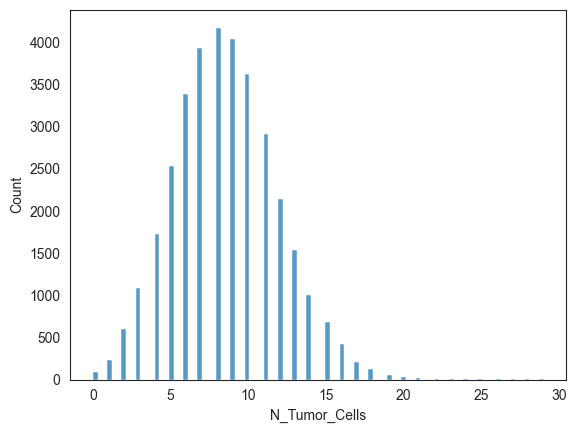

In [19]:
sns.histplot(data=df1, x="N_Tumor_Cells")
plt.show()

Most tumor cells have around 10 tumor cells in their neighborhood.

## 4.4 Clustering tumor cells



BigQuery Geospatial analytics provides additional functions for analyzing spatial data. Here, we utilized the [ST_CLUSTERDBSCAN](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_clusterdbscan) function to identify spatial clusters of tumor cells. This function implements [the DBSCAN algorithm](https://en.wikipedia.org/wiki/DBSCAN), which is capable of identifying high-density clusters of data.

In [13]:
query = """
WITH cells AS (
    SELECT CellID, X_centroid, Y_centroid,
      ST_GeogPoint(X_centroid/258080 ,Y_centroid/258080 ) as p
    FROM `isb-cgc-bq.HTAN_versioned.imaging_level4_HMS_mel_mask_r3`
    WHERE HTAN_Biospecimen_ID='HTA7_1_3'
      AND X_centroid > 23076.9 AND X_centroid < 30384.6
      AND Y_centroid > 9615.3 AND Y_centroid < 15000
      AND SOX10_cellRingMask > 3704.5
      AND (S100B_cellRingMask > 7589.48 OR CD63_cellRingMask > 570.68 )
)
SELECT CellID, X_centroid, Y_centroid, ST_CLUSTERDBSCAN(p, 20, 10) OVER () AS cluster_num
FROM cells
ORDER BY cluster_num
"""
df = pandas_gbq.read_gbq(query,project_id=project_id)
df

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,CellID,X_centroid,Y_centroid,cluster_num
0,422755,29314.869565,11592.782609,<NA>
1,334789,28309.099448,10379.027624,<NA>
2,690827,23460.790323,14693.612903,<NA>
3,639562,25358.893023,14168.279070,<NA>
4,517362,25740.903846,12798.474359,<NA>
...,...,...,...,...
34597,412125,28630.460526,11454.868421,18
34598,411957,28641.329897,11455.010309,18
34599,413510,28633.682540,11478.051587,18
34600,413509,28602.771144,11475.915423,18


The following code generates an image depicting the locations of tumor cells, with each cell colored according to the cluster to which it belongs.

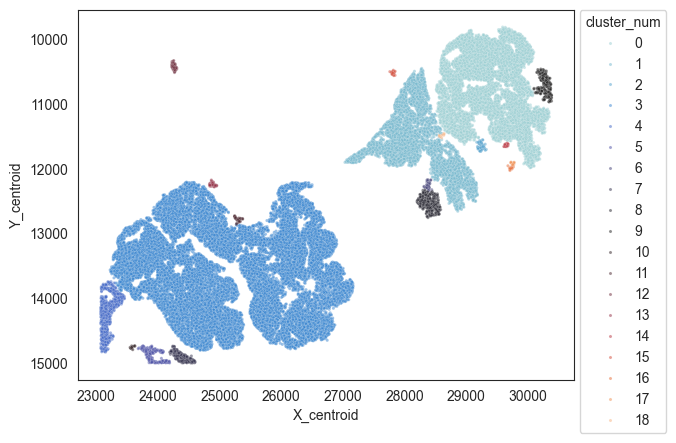

In [14]:
df1 = df.dropna().copy()
df1['cluster_num'] = df1['cluster_num'].astype(str)

# Plot it
sns.set_style("white")
g=sns.scatterplot(data=df1, y="Y_centroid", x="X_centroid", hue='cluster_num',
                  s=5,   alpha = 0.5 , palette="icefire")
sns.move_legend(g, "upper right", bbox_to_anchor=(1.2, 1.02))
g.invert_yaxis()

# 5. Relevant links and citations

*   [Link to the Manuscript](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and)
*   [Minerva Link showing an image of HTA7_1_3](https://labsyspharm.github.io/HTA-MELATLAS-1/stories/MEL1-full-story.html)
*   [Link with the functions available in BigQuery geospatial analyticis](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions)

